# Decompose the IVT field into a background and an anomaly component


This notebook applies the Top-hat by Reconstruction (THR) algorithm on the computed IVT from the previous step, and the outputs will be used for AR detection in the next notebook.

In production you can use the `scripts/compute_thr_singlefile.py` or `scripts/compute_thr_multifile.py` for this step.


## Input data

* `ivt_s_6_1984_Jan.nc`: Integrated Vapor Transport (IVT), in $kg/(m \cdot s)$.

## Steps

1. Make sure you have successfully run the previous notebook.
2. Execute the following code blocks in sequence.


## Results

* `ivt_s_6_1984_Jan-THR-kernel-t16-s6.nc`: decomposition of IVT using the THR algorithm, into a reconstruction component (`ivt_rec`) and the anomaly component (`ivt_ano`), both in $kg/(m \cdot s)$.

## Plotting package

Note that to create plots, you will need to install the `cartopy` plotting package. Installation using `conda`:

```
conda install cartopy
```


## Set some global parameters

- Set the path of the input netCDF file, the id of the IVT data, the folder to save the outputs.

- `SHIFT_LON` shifts the data along the x-dimension by 80 degrees so the Pacific and Atlantic oceans are centered.

- `KERNEL` is the most important parameter. It is a list/tuple of ints, specifying the shape of the kernel (aka structuring element) during the grey erosion process. Read the paper for more detailed explanations. A rule-of-thumb is that you should set the kernel size to be consistent with the typical synoptic spatio-temporal scales.

E.g.

Assuming the data is 6-hourly, at $0.75 \times 0.75$ degree longitude/latitude resolution. We want the temporal scale to be about a week, therefore $t = 16$. This is because 16 time steps of 6-hourly data is 4 days, and the **total** length is $16 \times 2 + 1 = 33$ time steps, giving $33 \times 6 = 108 hrs$, about a week's time. The extra added time step is to ensure an odd numbered kernel length.

Similarly, for the spatial scale we want it to be about $1000 km$. With $s=6$ and a horizontal resolution of $0.75 \times 0.75$ degrees, this gives a length of $6 \times 2 + 1 = 13$ grid cells, about $1140 \, km$.

Combing the above: `KERNEL=[16, 6, 6]`.

If your input data have $0.25 \times 0.25$ degree horizontal resolution, then $s$ should be scaled to $18$ to be consistent.

In [2]:
%matplotlib inline
import os
import numpy as np
from ipart.utils import funcs
from ipart import thr

## Parameters

#-----------IVT data----------------------
IVT_FILE=os.path.join('.', 'IVT-2022-06.nc')
VARIN='ivt'          # data id in nc file

SHIFT_LON=0  # shift longitudinally to center Pacific and Atlantic

#-------Structuring element for erosion (E)-------
KERNEL=[30,18,18]   # half length of time (time steps), and half length of spatial (number of grids)

#------------------Output folder------------------
OUTPUTDIR=os.path.abspath('.')

Then read in the input data, crop the desired latitude, and shift the longitude.

In [3]:
#-----------Read in data----------------------
var=funcs.readNC(IVT_FILE, 'ivt')

#-----------------Shift longitude-----------------
lon=var.getLongitude()
var=var.shiftLon(SHIFT_LON)

print('var.shape=', var.shape)

var.shape= (120, 165, 201)


Perform the THR process. This might take a couple of minutes (depending on your machine of cause). And save the output to the same directory as this notebook file.

Also note that the `thr.THR()` function accepts an optional argument `oroNV`, which is to provide the algorithm with some surface elevation information, with the help of which detection sensitivity of landfalling ARs can be enhanced. We are not covering this in this basic usage tutorial, the users are invited to experiment further on their own. 

In [4]:
#----------------------Do THR----------------------
ivt, ivtrec, ivtano=thr.THR(var, KERNEL)


# <THR>: Computing erosion ...

# <THR>: Computing reconstruction ...


Then save the outputs to disk.

In [5]:
#--------Save------------------------------------
if not os.path.exists(OUTPUTDIR):
    os.makedirs(OUTPUTDIR)

fname=os.path.split(IVT_FILE)[1]
file_out_name='%s-THR-kernel-t%d-s%d.nc'\
        %(os.path.splitext(fname)[0], KERNEL[0], KERNEL[1])

abpath_out=os.path.join(OUTPUTDIR,file_out_name)
print('\n# Saving output to:\n',abpath_out)
funcs.saveNC(abpath_out, ivt, 'w')
funcs.saveNC(abpath_out, ivtrec, 'a')
funcs.saveNC(abpath_out, ivtano, 'a')


# Saving output to:
 f:\AR_Analysis\2022\June\IVT-2022-06-THR-kernel-t30-s18.nc


Create some plots using results at an arbitrary time point.


# <getRange>: Get quantiles for vars
# <getQuantiles>: 0.001 left quantile: 0.000000.  0.999 right quantile: 571.519287.
# <getQuantiles>: 0.005 left quantile: 0.000000.  0.995 right quantile: 517.073547.
# <getQuantiles>: 0.010 left quantile: 0.000000.  0.990 right quantile: 476.982605.
# <getQuantiles>: 0.025 left quantile: 0.000000.  0.975 right quantile: 412.108124.
# <getQuantiles>: 0.050 left quantile: 0.000000.  0.950 right quantile: 346.114288.
# <getQuantiles>: 0.100 left quantile: 0.000000.  0.900 right quantile: 340.611481.


C:\Users\User\AppData\Local\Temp\ipykernel_17656\2847522810.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


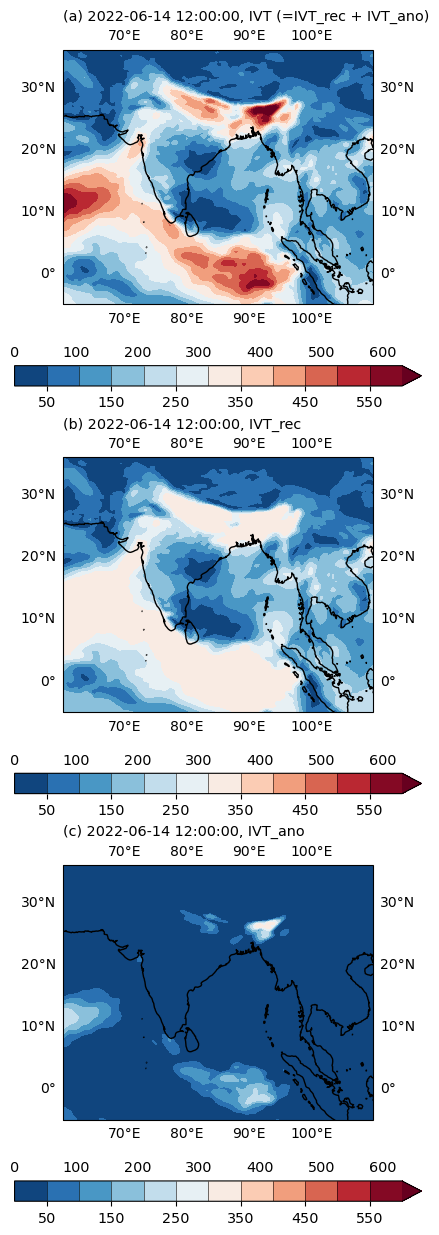

In [7]:
#------- Plot a figure -----------
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from ipart.utils import plot

figure=plt.figure(figsize=(7,15),dpi=100)
idx=54  # select the 101th time step from the beginning
time_str=ivt.getTime()[idx]

plot_vars=[ivt.data[idx], ivtrec.data[idx], ivtano.data[idx]]
iso=plot.Isofill(plot_vars, 12, 1, 1, min_level=0, qr=0.001)
titles=['IVT (=IVT_rec + IVT_ano)', 'IVT_rec', 'IVT_ano']

for ii, vii in enumerate(plot_vars):
    axii=figure.add_subplot(3,1,ii+1,projection=ccrs.PlateCarree())
    
    plot.plot2(vii, iso, axii,
            title='%s, %s' %(str(time_str), titles[ii]),
               xarray=ivt.getLongitude(),
               yarray=ivt.getLatitude(),
            legend='local',
            fix_aspect=False)

figure.show()